In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
from xgboost import XGBRegressor

In [3]:
df = pd.read_csv('TLogs/master_drone_dataset.csv')
print(f"Original data size: {len(df)}")

Original data size: 115307


In [4]:
df_clean = df[
    (df['voltage']> 20) &
    (df['current'] > 0.5) &
    (df['throttle'] > 0)
].copy()
print(f"Clean flight data size: {len(df_clean)}")

Clean flight data size: 6571


In [5]:
# Calculate Power (Watts) as the main effort metric
df_clean['power_watts'] = df_clean['voltage'] * df_clean['current']

# Calculate Efficiency (Amps per Volt) to capture voltage sag dynamics
df_clean['efficiency_index'] = df_clean['current'] / df_clean['voltage']

# Add rolling average for current (5s window) to give the model history/memory
# We group by 'source_file' to ensure we don't mix data from different flights
df_clean['current_smooth_5s'] = df_clean.groupby('source_file')['current'].transform(
    lambda x: x.rolling(window=20, min_periods=1).mean()
)

# Drop any NaNs generated by the rolling window
df_clean = df_clean.dropna()

In [6]:
features = [
    'throttle', 'current', 'voltage', 'altitude', 
    'groundspeed', 'roll', 'pitch', 
    'power_watts', 'efficiency_index', 'current_smooth_5s'
]
target = 'battery_remaining'

X = df_clean[features]
y = df_clean[target]

# Split into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Setup the pipeline with scaling and XGBoost
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror'))
])

# Define hyperparameters to test
param_grid = {
    'model__n_estimators': [100, 300, 500],
    'model__max_depth': [5, 7, 9],
    'model__learning_rate': [0.05, 0.1 , 0.2]
}

# Run GridSearch
print("Training model...")
search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1)
search.fit(X_train, y_train)

print(f"Best params: {search.best_params_}")

Training model...
Best params: {'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 500}


------------------------------
Final R2 Score: 0.9820
Mean Absolute Error: 0.25%
------------------------------


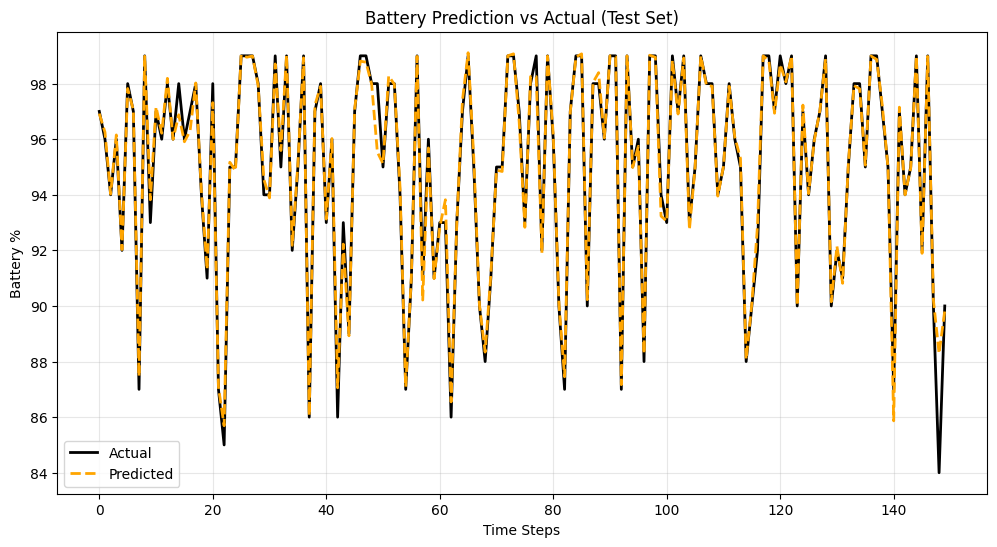

In [8]:
# Predict on test set
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("-" * 30)
print(f"Final R2 Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.2f}%")
print("-" * 30)

# Plot actual vs predicted for the first 150 points
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:150], label='Actual', color='black', linewidth=2)
plt.plot(y_pred[:150], label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title("Battery Prediction vs Actual (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("Battery %")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()